In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import normalize, LabelEncoder

# Librosa (the mother of audio files)
import librosa
import librosa.display
import warnings
import IPython.display as ipd

from google.colab import drive
drive.mount('/content/drive')
dataset_dir = '/content/drive/MyDrive/Capstone Project ML/donateacry_corpus_cleaned_and_updated_data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Total files in hungry folder: 624
Total files in discomfort folder: 336
Total files in burping folder: 251
Total files in tired folder: 432
Total files in belly_pain folder: 375


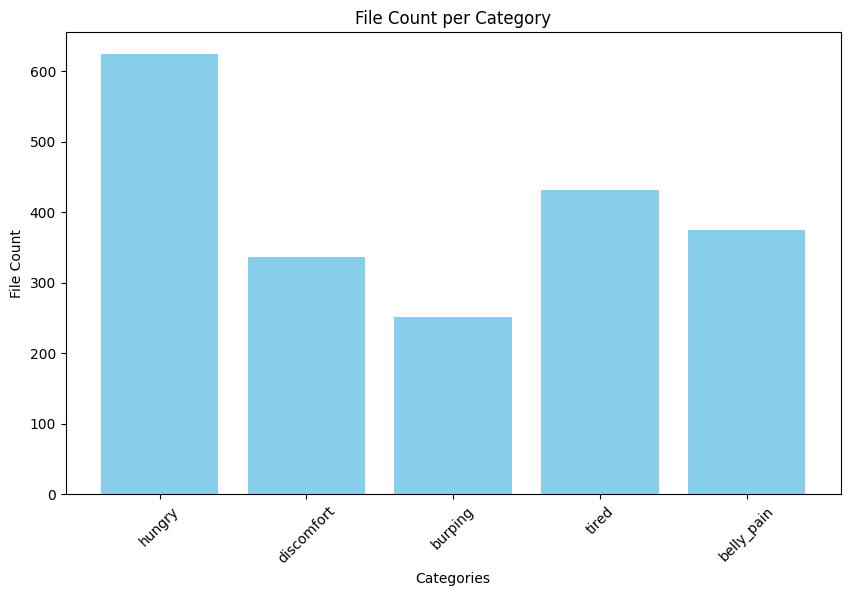

In [ ]:
# Menyimpan satu sampel audio dari setiap folder
sample_files = {}
# Membuat dictionary untuk menyimpan jumlah file pada setiap folder
folder_counts = {}

# Melakukan iterasi pada setiap folder (kategori)
for category in os.listdir(dataset_dir):
    category_dir = os.path.join(dataset_dir, category)
    if os.path.isdir(category_dir):
        # Mendapatkan daftar file .wav dalam folder
        wav_files = [filename for filename in os.listdir(category_dir) if filename.endswith(".wav")]
        file_count = len(wav_files)
        folder_counts[category] = file_count
        if file_count > 0:
            sample_files[category] = os.path.join(category_dir, wav_files[0])

# Mencetak hasil jumlah file dalam setiap folder
for category, count in folder_counts.items():
    print(f"Total files in {category} folder: {count}")

# Visualisasi dengan grafik batang
categories = list(folder_counts.keys())
counts = list(folder_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('File Count')
plt.title('File Count per Category')
plt.xticks(rotation=45)
plt.show()

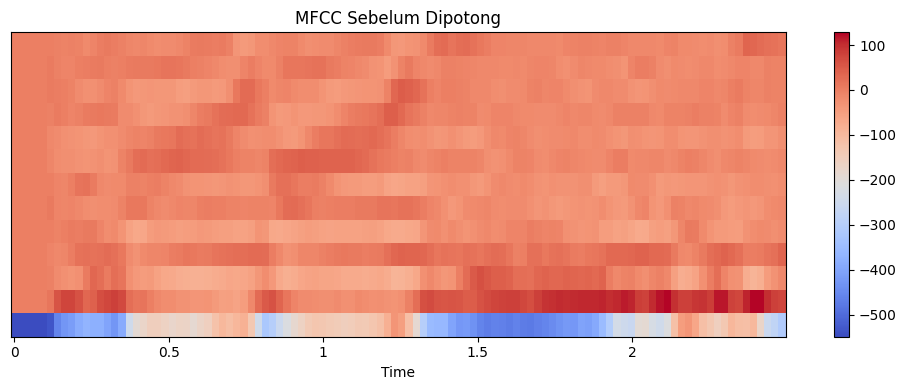

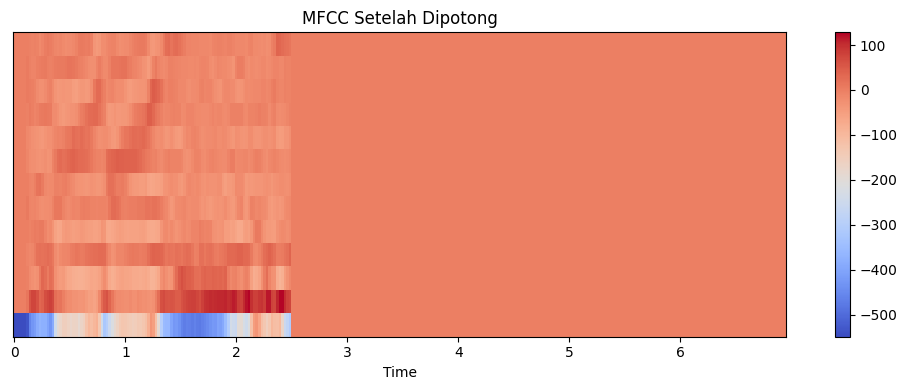

In [ ]:
# Inisialisasi list untuk menyimpan fitur audio dan label
audio_features = []
labels = []

# Menentukan panjang maksimum fitur (jumlah frame MFCC)
max_length = 300 # Sesuaikan panjang sesuai kebutuhan Anda

# Fungsi untuk menampilkan MFCC
def plot_mfcc(mfcc, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Melakukan iterasi pada setiap folder (kategori)
for category in os.listdir(dataset_dir):
    category_dir = os.path.join(dataset_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith(".wav"):
            filepath = os.path.join(category_dir, filename)
            # Membaca file audio
            audio, sr = librosa.load(filepath, sr=None)  # sr=None agar sampling rate asli digunakan
            # Ekstraksi fitur audio (misalnya, MFCC)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

            # Visualisasi MFCC sebelum pemotongan
            if len(audio_features) == 0:  # hanya visualisasi untuk file pertama
                plot_mfcc(mfccs, 'MFCC Sebelum Dipotong')

            # Zero-padding untuk menyamakan panjang fitur
            if mfccs.shape[1] < max_length:
                pad_width = max_length - mfccs.shape[1]
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfccs = mfccs[:, :max_length]

            # Visualisasi MFCC setelah pemotongan
            if len(audio_features) == 0:  # hanya visualisasi untuk file pertama
                plot_mfcc(mfccs, 'MFCC Setelah Dipotong')

            # Menyimpan fitur dan label
            audio_features.append(mfccs)
            labels.append(category)


# Konversi label ke angka
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [ ]:
# Split data menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(audio_features, labels, test_size=0.2, random_state=42)

# Konversi data ke bentuk array NumPy
X_train = np.array(X_train)
X_test = np.array(X_test)

print("Jumlah Training Sampel : ", X_train.shape)
print("Jumlah Testing Sampel : ", X_test.shape)
print("Jumlah Training Label : ", y_train.shape)
print("Jumlah Testing Label : ", y_test.shape)

Jumlah Training Sampel :  (1614, 13, 300)
Jumlah Testing Sampel :  (404, 13, 300)
Jumlah Training Label :  (1614,)
Jumlah Testing Label :  (404,)


Playing sample audio from hungry category


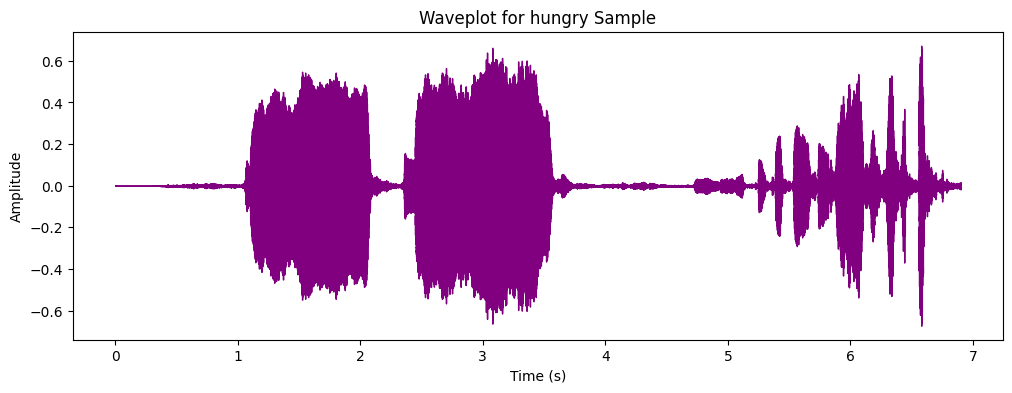

Playing sample audio from discomfort category


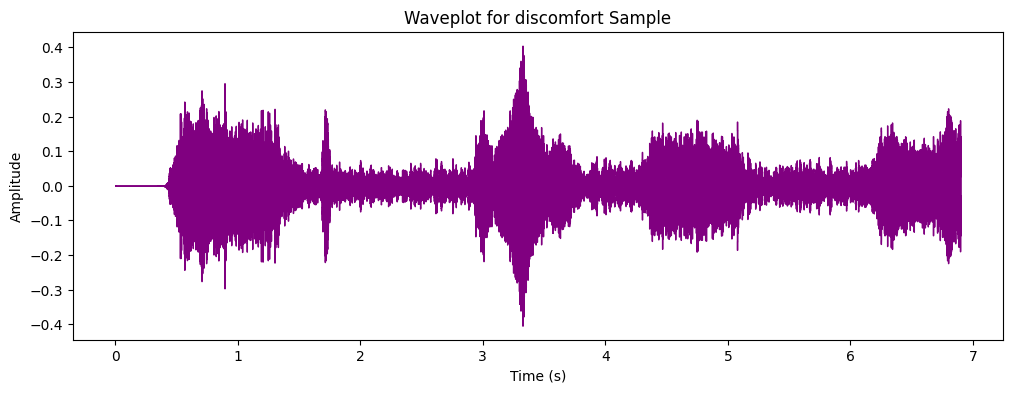

Playing sample audio from burping category


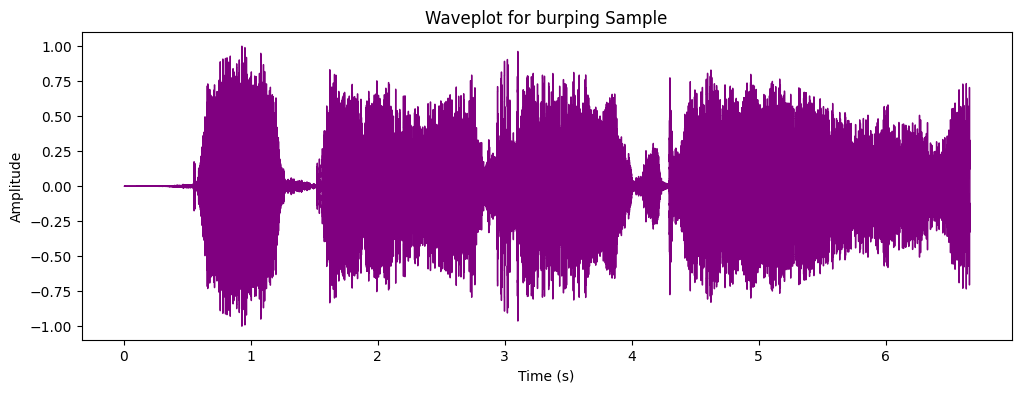

Playing sample audio from tired category


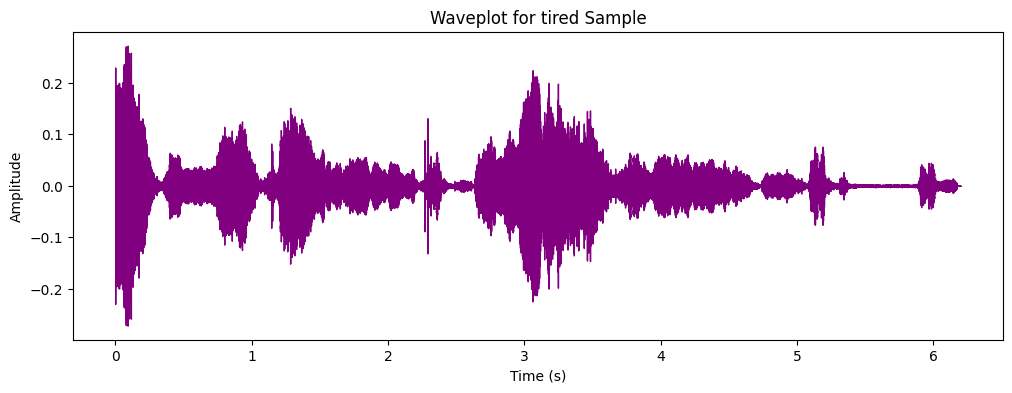

Playing sample audio from belly_pain category


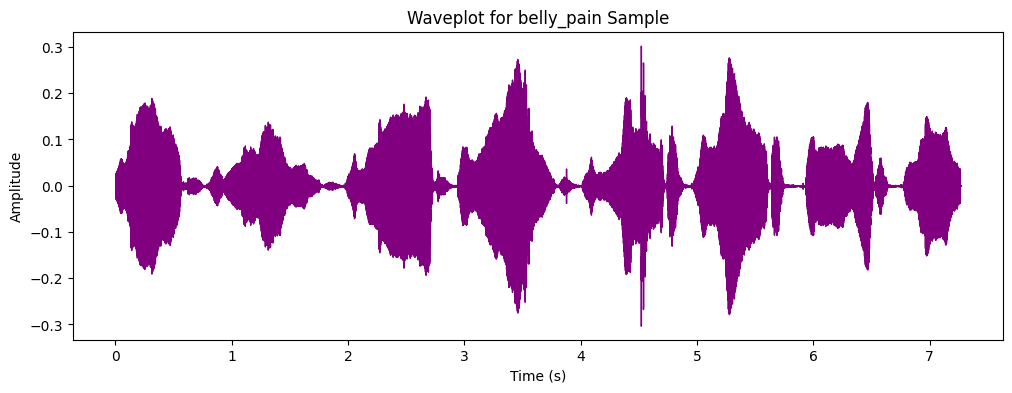

In [ ]:
# Visualisasi dengan grafik batang jumlah file per kategori
categories = list(folder_counts.keys())
counts = list(folder_counts.values())

# Visualisasi waveplot dan memutar audio untuk satu sampel audio dari setiap kategori
for category, sample_audio in sample_files.items():
    samples, sample_rate = librosa.load(sample_audio, sr=None)
    print(f"Playing sample audio from {category} category")
    ipd.display(ipd.Audio(samples, rate=sample_rate))
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(samples, sr=sample_rate, color='purple')
    plt.title(f'Waveplot for {category} Sample')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

In [ ]:
# Membangun model RNN dengan LSTM
rnn_model = keras.Sequential([
    layers.LSTM(512, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512,activation='relu'),
    layers.Dense(256,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if (logs.get('val_accuracy') >= 0.90):
#             print("\nReached 91% accuracy so cancelling training!")
#             self.rnn_model.stop_training = True

rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = myCallback()
# Latih model
rnn_history = rnn_model.fit(
    X_train,  # Input data for training
    y_train,  # Target data for training
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    # callbacks = [callbacks]# Validation data
)

# Evaluasi model
rnn_loss, rnn_acc = rnn_model.evaluate(X_test, y_test)
print(f"Loss: {rnn_loss} Test accuracy: {rnn_acc}")

Epoch 1/50
26/26 [==============================] - 4s 35ms/step - loss: 1.9817 - accuracy: 0.4232 - val_loss: 1.8698 - val_accuracy: 0.5545
Epoch 2/50
26/26 [==============================] - 0s 12ms/step - loss: 1.6999 - accuracy: 0.5099 - val_loss: 1.7041 - val_accuracy: 0.6386
Epoch 3/50
26/26 [==============================] - 0s 14ms/step - loss: 1.3963 - accuracy: 0.6642 - val_loss: 1.2930 - val_accuracy: 0.8094
Epoch 4/50
26/26 [==============================] - 0s 15ms/step - loss: 1.1988 - accuracy: 0.7323 - val_loss: 1.1194 - val_accuracy: 0.8218
Epoch 5/50
26/26 [==============================] - 0s 15ms/step - loss: 1.0617 - accuracy: 0.7974 - val_loss: 1.0028 - val_accuracy: 0.8589
Epoch 6/50
26/26 [==============================] - 0s 16ms/step - loss: 0.9891 - accuracy: 0.8352 - val_loss: 0.9288 - val_accuracy: 0.8589
Epoch 7/50
26/26 [==============================] - 0s 15ms/step - loss: 0.9158 - accuracy: 0.8618 - val_loss: 0.8926 - val_accuracy: 0.8812
Epoch 8/50
26

In [ ]:
print("Number of training samples (X_train):", X_train.shape[0])
print("Number of training labels (y_train):", len(y_train))
print("Number of test samples (X_test):", X_test.shape[0])
print("Number of test labels (y_test):", len(y_test))

Number of training samples (X_train): 1614
Number of training labels (y_train): 1614
Number of test samples (X_test): 404
Number of test labels (y_test): 404


In [ ]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 13, 512)           1665024   
                                                                 
 batch_normalization_1 (Bat  (None, 13, 512)           2048      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 13, 512)           0         
                                                                 
 dense_3 (Dense)             (None, 13, 512)           262656    
                                                                 
 dense_4 (Dense)             (None, 13, 256)           131328    
                                                                 
 dropout_4 (Dropout)         (None, 13, 256)           0         
                                                      

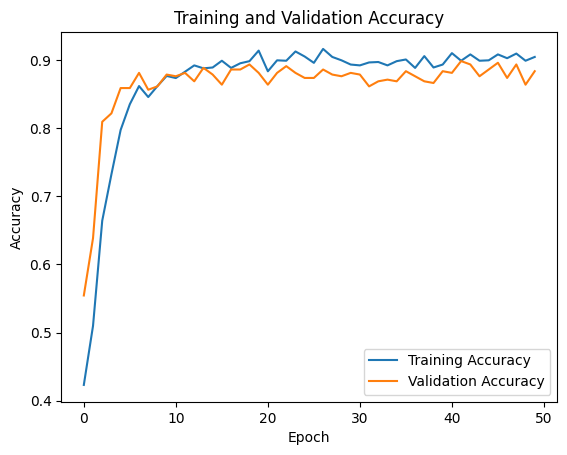

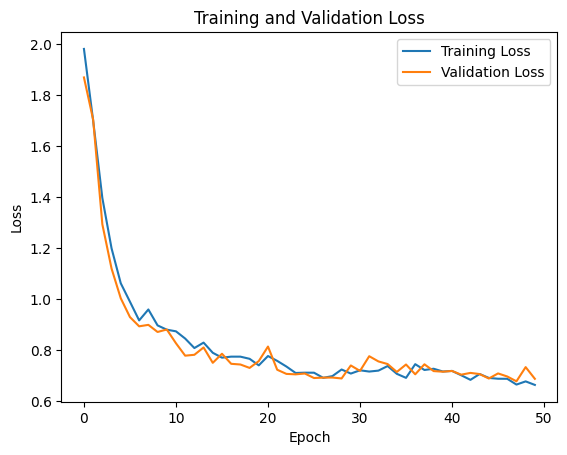

In [ ]:
import matplotlib.pyplot as plt

# Plot training history (accuracy and loss)
plt.plot(rnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Assuming audio_features is your input list
audio_features = np.array(audio_features)  # Convert the list to a NumPy array

# Normalisasi fitur
scaler = StandardScaler()
n_samples, n_features, n_frames = audio_features.shape
audio_features = audio_features.reshape(n_samples, n_features * n_frames)
audio_features = scaler.fit_transform(audio_features)
audio_features = audio_features.reshape(n_samples, n_features, n_frames)


In [ ]:
# Bentuk input untuk CNN
input_shape = (n_features, max_length, 1)
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout
# Membangun model CNN
cnn_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Kompilasi model CNN
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Melatih model CNN
cnn_history = cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2)
# Evaluasi model CNN
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test)
print(f"Loss: {cnn_loss}, Accuracy: {cnn_accuracy}")


Epoch 1/50
41/41 [==============================] - 3s 17ms/step - loss: 11.9202 - accuracy: 0.3602 - val_loss: 1.4496 - val_accuracy: 0.4427
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 1.4072 - accuracy: 0.4020 - val_loss: 1.3803 - val_accuracy: 0.4458
Epoch 3/50
41/41 [==============================] - 0s 7ms/step - loss: 1.3270 - accuracy: 0.4307 - val_loss: 1.3778 - val_accuracy: 0.4830
Epoch 4/50
41/41 [==============================] - 0s 7ms/step - loss: 1.2931 - accuracy: 0.4454 - val_loss: 1.3300 - val_accuracy: 0.4923
Epoch 5/50
41/41 [==============================] - 0s 7ms/step - loss: 1.3026 - accuracy: 0.4361 - val_loss: 1.3124 - val_accuracy: 0.4489
Epoch 6/50
41/41 [==============================] - 0s 7ms/step - loss: 1.2600 - accuracy: 0.4802 - val_loss: 1.2865 - val_accuracy: 0.4923
Epoch 7/50
41/41 [==============================] - 0s 6ms/step - loss: 1.2191 - accuracy: 0.4702 - val_loss: 1.2753 - val_accuracy: 0.4892
Epoch 8/50
41/41 

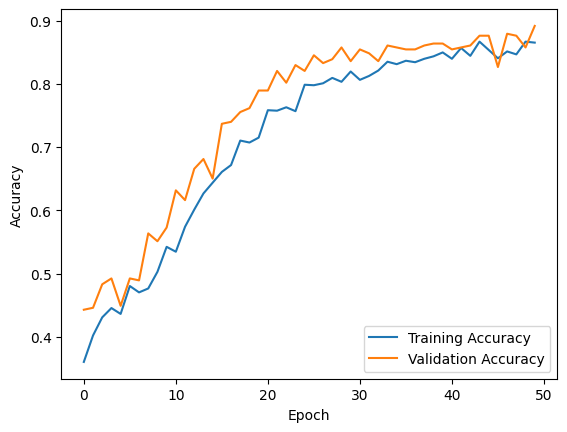

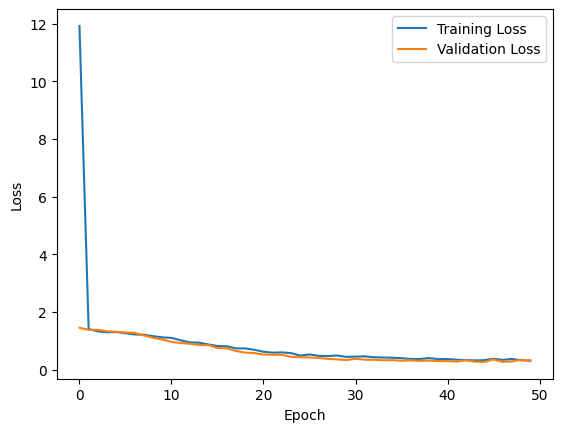

In [ ]:
# Visualisasi hasil pelatihan model CNN
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


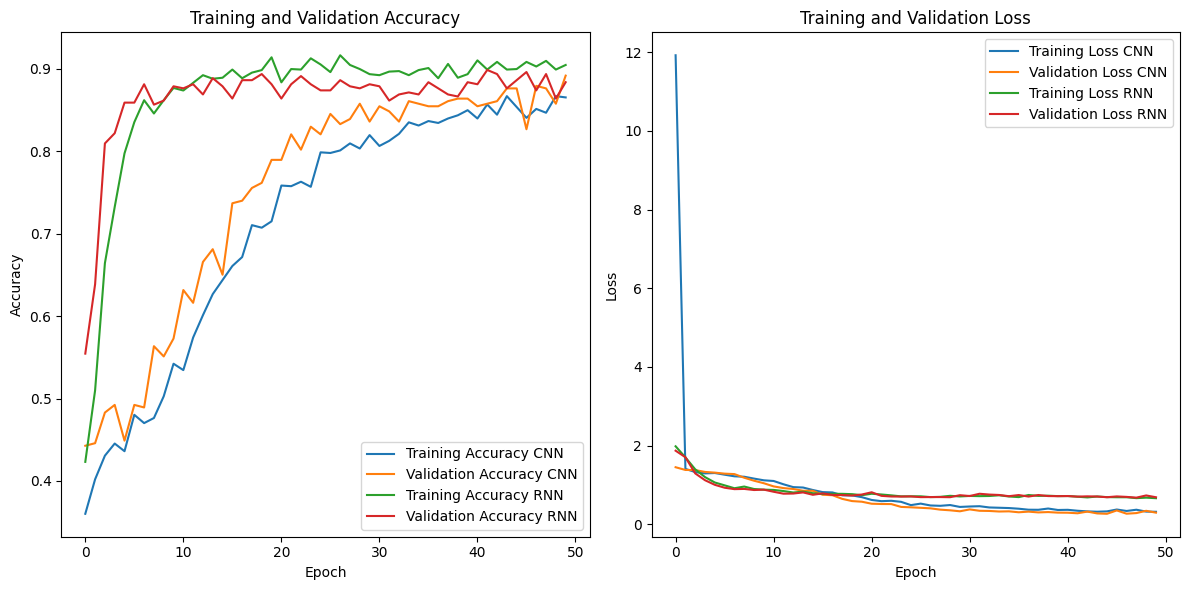

CNN Model - Loss: 0.2614625096321106, Accuracy: 0.8787128925323486
RNN Model - Loss: 0.6865478157997131, Accuracy: 0.8836633563041687


In [ ]:
import matplotlib.pyplot as plt

# Fungsi untuk visualisasi perbandingan
def plot_comparison(history1, history2, label1='Model 1', label2='Model 2'):
    # Plot akurasi pelatihan
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label=f'Training Accuracy {label1}')
    plt.plot(history1.history['val_accuracy'], label=f'Validation Accuracy {label1}')
    plt.plot(history2.history['accuracy'], label=f'Training Accuracy {label2}')
    plt.plot(history2.history['val_accuracy'], label=f'Validation Accuracy {label2}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot kehilangan pelatihan
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label=f'Training Loss {label1}')
    plt.plot(history1.history['val_loss'], label=f'Validation Loss {label1}')
    plt.plot(history2.history['loss'], label=f'Training Loss {label2}')
    plt.plot(history2.history['val_loss'], label=f'Validation Loss {label2}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

# Visualisasi perbandingan antara model CNN dan RNN
plot_comparison(cnn_history, rnn_history, label1='CNN', label2='RNN')

# Evaluasi akhir
print(f"CNN Model - Loss: {cnn_loss}, Accuracy: {cnn_accuracy}")
print(f"RNN Model - Loss: {rnn_loss}, Accuracy: {rnn_acc}")

In [ ]:
# Make predictions on the test set
rnn_predictions = rnn_model.predict(X_test)
cnn_predictions = rnn_model.predict(X_test)

# Convert predictions to class labels
rnn_predicted_labels = np.argmax(rnn_predictions, axis=1)
cnn_predicted_labels = np.argmax(rnn_predictions, axis=1)

# Convert numeric labels back to original labels using the label encoder
rnn_predicted_category_labels = label_encoder.inverse_transform(rnn_predicted_labels)
cnn_predicted_category_labels = label_encoder.inverse_transform(rnn_predicted_labels)

# Display some predictions
for i in range(10):  # Display predictions for the first 10 samples
    print(f"True Label: {label_encoder.classes_[y_test[i]]},\n RNN Predicted Label: {rnn_predicted_category_labels[i]},\n CNN Predicted Label: {cnn_predicted_category_labels[i]}\n\n")

13/13 [==============================] - 0s 5ms/step
True Label: tired,
 RNN Predicted Label: tired,
 CNN Predicted Label: tired


True Label: hungry,
 RNN Predicted Label: hungry,
 CNN Predicted Label: hungry


True Label: hungry,
 RNN Predicted Label: hungry,
 CNN Predicted Label: hungry


True Label: belly_pain,
 RNN Predicted Label: belly_pain,
 CNN Predicted Label: belly_pain


True Label: hungry,
 RNN Predicted Label: hungry,
 CNN Predicted Label: hungry


True Label: burping,
 RNN Predicted Label: tired,
 CNN Predicted Label: tired


True Label: burping,
 RNN Predicted Label: burping,
 CNN Predicted Label: burping


True Label: hungry,
 RNN Predicted Label: hungry,
 CNN Predicted Label: hungry


True Label: belly_pain,
 RNN Predicted Label: belly_pain,
 CNN Predicted Label: belly_pain


True Label: hungry,
 RNN Predicted Label: hungry,
 CNN Predicted Label: hungry


